In [261]:
from IPython.display import display, HTML
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.table import Table
import matplotlib.patches as mpatches  # Correctly importing mpatches
from matplotlib.font_manager import FontProperties
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline, AutoModel
import stanza
import arabic_reshaper
from bidi.algorithm import get_display
import pandas as pd
import torch
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import numpy as np


![image.png](attachment:image.png)

# 2. Core Concepts in NLP

## Tokenization - (Words, Sentences, Subwords)

<div dir="rtl">

<div dir="rtl">
 תהליך פירוק הטקס לחלקים קטנים יותר.
 
</div>

In [172]:
hebrew_text = """
הזאב הגדול הלך לבקר את כיפה אדומה
בבית החווה עם השער הכחול.
הצייד הגיע ישר אחריו והציל את כולם.
"""
display(HTML(f"<div dir='rtl' style='font-size:16px;'><pre style='font-family: inherit;'>{str}</pre></div>"))

In [173]:
# Create a blank image with a white background
font = ImageFont.truetype("/Users/nirkon/dev/fonts/Arial.ttf", 20)  # Use the uploaded Arial font
# Starting y-coordinate for drawing text
y = 10
x_padding = 5  # Padding around words
y_spacing = 40  # Space between lines

### לפי מילים

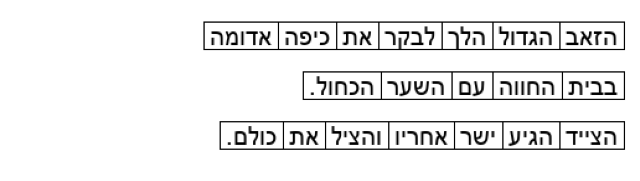

In [174]:

# Split text into lines and words
lines = hebrew_text.strip().split("\n")
words_per_line = [line.split() for line in lines]

# Create a blank image with a white background
img = Image.new('RGB', (500, 130), 'white')
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("/Users/nirkon/dev/fonts/Arial.ttf", 20)  # Use the uploaded Arial font

# Starting y-coordinate for drawing text
y = 10
x_padding = 5  # Padding around words
y_spacing = 40  # Space between lines

# Draw each word with a bounding box
for line_words in words_per_line:
    x = img.width - 10  # Start from the right side for RTL alignment
    for word in line_words:  # Reverse for RTL order
        # Calculate word size using textbbox
        bbox = draw.textbbox((0, 0), word, font=font)
        word_width = bbox[2] - bbox[0]
        word_height = 22
        
        # Draw the word
        draw.text((x - word_width, y), word[::-1], font=font, fill="black")
        
        # Draw the bounding box around the word
        draw.rectangle([x - word_width - x_padding, y, x + x_padding, y + word_height], outline="black")
        
        # Move left for the next word
        x -= word_width + 2 * x_padding
    y += y_spacing  # Move down for the next line

# Display the image in Jupyter using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

### לפי שורות

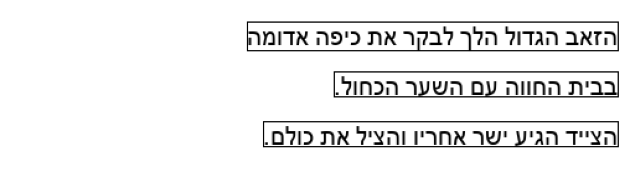

In [175]:
# Split text into lines
lines = hebrew_text.strip().split("\n")

# Create a blank image with a white background
img = Image.new('RGB', (500, 130), 'white')
draw = ImageDraw.Draw(img)
font = ImageFont.truetype("/mnt/data/Arial.ttf", 20)  # Use the uploaded Arial font

# Starting y-coordinate for drawing text
y = 10
x_padding = 5  # Padding around lines
y_spacing = 40  # Space between lines

# Draw each line with a bounding box
for line in lines:
    # Calculate the width of the entire line by summing each word's width
    line_width = sum(draw.textbbox((0, 0), word, font=font)[2] for word in line.split()) + (x_padding * (len(line.split()) - 1))
    line_height = draw.textbbox((0, 0), line, font=font)[3]  # Height of the line

    # Start drawing from the right side for RTL alignment
    x = img.width - 10

    # Draw each word in the line
    for word in line.split():  # RTL by reversing word order
        bbox = draw.textbbox((0, 0), word, font=font)
        word_width = bbox[2] - bbox[0]
        
        # Draw the word
        draw.text((x - word_width, y), word[::-1], font=font, fill="black")
        
        # Move left for the next word
        x -= word_width + x_padding

    # Draw bounding box around the entire line
    draw.rectangle([img.width - line_width - 10, y, img.width - 10, y + line_height], outline="black")
    
    y += y_spacing  # Move down for the next line

# Display the image in Jupyter using matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

### לפי משפטים

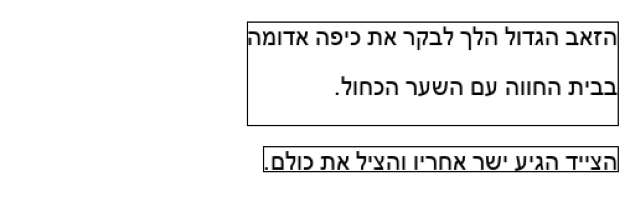

In [176]:
# Split text into paragraphs by "." while preserving line breaks
paragraphs = [p.strip() + "." for p in hebrew_text.split(".") if p.strip()]

# Create a blank image with a white background
img = Image.new('RGB', (500, 150), 'white')
draw = ImageDraw.Draw(img)

# Starting y-coordinate for drawing text
y = 10
paragraph_spacing = 20  # Additional space between paragraphs

# Draw each paragraph, preserving line breaks within each paragraph
for paragraph in paragraphs:
    # Split each paragraph into lines based on line breaks within the paragraph
    lines = paragraph.splitlines()  # Keeps all line breaks inside each paragraph
    
    # Determine the bounding box for the paragraph based on its lines
    max_line_width = 0
    paragraph_height = 0

    # Measure the maximum line width and cumulative height
    for line in lines:
        line_width = sum(draw.textbbox((0, 0), word, font=font)[2] for word in line.split()) + (x_padding * (len(line.split()) - 1))
        max_line_width = max(max_line_width, line_width)
        line_height = draw.textbbox((0, 0), line, font=font)[3]
        paragraph_height += line_height + y_spacing

    # Draw bounding box for the paragraph
    draw.rectangle([img.width - max_line_width - 10, y, img.width - 10, y + paragraph_height - y_spacing], outline="black")

    # Draw each line within the paragraph
    for line in lines:
        # Start drawing from the right side for RTL alignment
        x = img.width - 10

        # Draw each word in the line
        for word in line.split():  # RTL by reversing word order
            bbox = draw.textbbox((0, 0), word, font=font)
            word_width = bbox[2] - bbox[0]
            
            # Draw the word
            draw.text((x - word_width, y), word[::-1], font=font, fill="black")
            
            # Move left for the next word
            x -= word_width + x_padding

        y += y_spacing  # Move down for the next line

    # Add extra space after each paragraph
    y += paragraph_spacing

# Display the image in Jupyter using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

### 

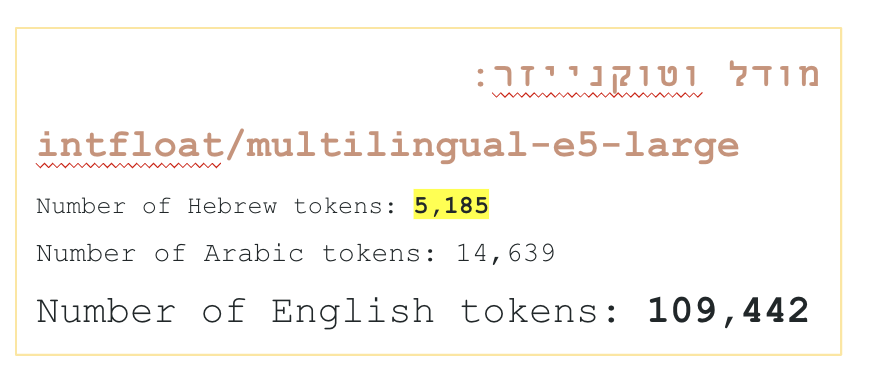

In [177]:

# Load the tokenizer for the model
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large")

# Define the sentence and tokenize it
sentence = "הזאב הגדול הלך לבקר את כיפה אדומה בבית החווה עם השער הכחול."
tokens = tokenizer.tokenize(sentence)
print(tokens)

['▁הז', 'אב', '▁הגדול', '▁ה', 'לך', '▁לבקר', '▁את', '▁כי', 'פה', '▁א', 'דומה', '▁בבית', '▁ה', 'חווה', '▁עם', '▁ה', 'שער', '▁הכ', 'חול', '.']


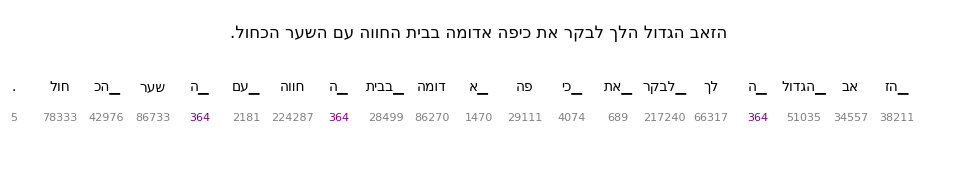

In [178]:

# Tokenize the sentence and get token IDs
tokens = tokenizer.tokenize(sentence)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 2))

# Plot the sentence in reverse (Hebrew is right-to-left)
ax.text(0.5, 0.85, sentence[::-1], ha='center', va='center', fontsize=12)

# Plot each token in reverse order with its token ID below it, with more vertical space
for i, (token, token_id) in enumerate(zip(tokens[::-1], token_ids[::-1])):
    # Token text with adjusted vertical space
    ax.text(i / len(tokens), 0.5, token[::-1], ha='center', va='center', fontsize=10)
    # Token ID with more space below the token, in purple if token_id is 364
    color = 'purple' if token_id == 364 else 'gray'
    ax.text(i / len(tokens), 0.3, f"{token_id}", ha='center', va='center', fontsize=8, color=color)

# Remove axes
ax.axis('off')

# Show the plot
plt.show()

In [179]:
print(f"Number of Words: {len(sentence.split())}, Number of Tokens: {len(tokens)}, ratio = {len(tokens) / len(sentence.split())}")

Number of Words: 12, Number of Tokens: 20, ratio = 1.6666666666666667


## Part-of-Speech Tagging

In [180]:
nlp = stanza.Pipeline('he', processors='tokenize,mwt,pos,lemma,depparse')

# UPOS to Hebrew mapping
upos_to_hebrew = {
    'ADJ': 'שם תואר',           # Adjective
    'ADP': 'מילת יחס',          # Adposition
    'ADV': 'תואר הפועל',        # Adverb
    'AUX': 'פועל עזר',          # Auxiliary
    'CCONJ': 'מילת חיבור',      # Coordinating Conjunction
    'DET': 'מילית יידוע',       # Determiner
    'INTJ': 'מילת קריאה',       # Interjection
    'NOUN': 'שם עצם',           # Noun
    'NUM': 'מספר',              # Numeral
    'PART': 'מילית',            # Particle
    'PRON': 'כינוי גוף',        # Pronoun
    'PROPN': 'שם פרטי',         # Proper Noun
    'PUNCT': 'פיסוק',           # Punctuation
    'SCONJ': 'מילת שעבוד',      # Subordinating Conjunction
    'SYM': 'סימן',              # Symbol
    'VERB': 'פועל',             # Verb
    'X': 'אחר'                  # Other
}

2024-11-12 00:31:45 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-11-12 00:31:45 INFO: Downloaded file to /Users/nirkon/stanza_resources/resources.json
2024-11-12 00:31:46 INFO: Loading these models for language: he (Hebrew):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2024-11-12 00:31:46 INFO: Using device: cpu
2024-11-12 00:31:46 INFO: Loading: tokenize
/Users/nirkon/free_dev/nlp-intro/.venv/lib/python3.9/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious p

In [181]:
# Function to reshape and reorder RTL text
def reshape_rtl(text):
    if text is None or text == '-':
        return text
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

# Process the text
sentence_text = "הזאבה הגדולה הלכה לבקר את כיפה אדומה בבית החווה עם השער הכחול."
doc = nlp(sentence_text)

# Prepare data for the DataFrame
data = []
for sent in doc.sentences:
    for word in sent.words:
        # Safely get features
        feats = word.feats if word.feats is not None else '-'
        # Get UPOS tag and translate to Hebrew
        upos_hebrew = upos_to_hebrew.get(word.upos, 'אחר')
        data.append({
            'תכונות': feats, 
            'סוג': upos_hebrew[::-1],
            'צורת בסיס': word.lemma[::-1],
            'מילה': word.text[::-1]
        })

# Create DataFrame
df = pd.DataFrame(data)

# Apply RTL reshaping to the entire DataFrame
df = df.applymap(reshape_rtl)

# Function to highlight lemmas that differ from the original word
def highlight_different_lemmas(row):
    styles = [''] * len(row)
    if row['צורת בסיס'] != row['מילה']:
        idx = row.index.get_loc('צורת בסיס')
        styles[idx] = 'background-color: red'
    if row['סוג'] == 'פועל':
        # Index of the 'למה' column
        idx = row.index.get_loc('סוג')
        styles[idx] = 'color: green'
    if row['סוג'] == 'שם עצם':
        # Index of the 'למה' column
        idx = row.index.get_loc('סוג')
        styles[idx] = 'color: blue'
    return styles

# Apply the highlighting to the DataFrame
df_style = df.style.apply(highlight_different_lemmas, axis=1)

# Set text alignment and header style
df_style = df_style.set_properties(**{'text-align': 'right'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)

# Display the styled DataFrame
df_style

/var/folders/3r/z8t8r1zn611b4rhfhyjvxpc80000gq/T/ipykernel_74400/875609837.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(reshape_rtl)


,תכונות,סוג,צורת בסיס,מילה
0,Definite=Def|PronType=Art,מילית יידוע,ה,ה
1,Gender=Fem|Number=Sing,שם עצם,זאבה,זאבה
2,Definite=Def|PronType=Art,מילית יידוע,ה,ה
3,Gender=Fem|Number=Sing,שם תואר,גדול,גדולה
4,Gender=Fem|HebBinyan=PAAL|Number=Sing|Person=3|Tense=Past|Voice=Act,פועל,הלך,הלכה
5,HebBinyan=PIEL|VerbForm=Inf|Voice=Act,פועל,ביקר,לבקר
6,Case=Acc,מילת יחס,את,את
7,Gender=Fem|Number=Sing,שם עצם,כיפה,כיפה
8,Gender=Fem|Number=Sing,שם תואר,אדום,אדומה
9,-,מילת יחס,ב,ב


## Name Entity Recognition (NER)

In [182]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("avichr/heBert_NER")
model = AutoModelForTokenClassification.from_pretrained("avichr/heBert_NER")
model.to(device)

# Create NER pipeline
nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True, device=device)

MPS device is available.


/Users/nirkon/free_dev/nlp-intro/.venv/lib/python3.9/site-packages/transformers/pipelines/token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [183]:
# Example Hebrew text
text_bad = """
רגע לפני שידור התחקיר בחיפה, השר לביטחון לאומי 
ניסה לסנדל ולמנוע את שידור המסמך המחריד אך
בקשתו נדחתה בבית המשפט המחוזי בירושלים. 
לאחר ההחלטה דרוקר מסר ל״מעריב״
כי ״העובדה שבן גביר עתר בכלל לביהמ"ש 
בידיעה ברורה שאין לו שום קייס, כנראה, מוכיחה כמה חשוב לו
שהחומרים הללו לא יתפרסמו״. 
"""

In [201]:
def get_entities(text):
    ner_results = nlp(text)
    entities = []
    for entity in ner_results:
        entities.append({
            'start': entity['start'],
            'end': entity['end'],
            'word': entity['word'],
            'label': entity['entity_group']
        })
    return entities

In [185]:
def highlight_entities(text, entities):
    """
    Highlights entities in the text by wrapping them in <span> tags with styles.
    Appends the entity label in parentheses after the entity word.
    """
    highlighted_text = ""
    last_idx = 0

    for entity in entities:
        start = entity['start']
        end = entity['end']
        label = entity['label']
        
        # Add text before the entity
        highlighted_text += text[last_idx:start]
        
        # Define colors for different entity types
        label_colors = {
            'B_PERS': 'blue',    # Person
            'B_LOC': 'green',   # Location
            'B_ORG': 'orange',  # Organization
            'B_MISC': 'purple'  # Miscellaneous
        }
        
        # Choose color based on label, default to black if label not recognized
        color = label_colors.get(label, 'black')
        
        # Extract the entity text
        entity_text = text[start:end]
        
        # Wrap the entity in a span with the chosen color and append the label
        highlighted_text += f'<span style="color: {color}; font-weight: bold;">{entity_text} ({label})</span>'
        
        # Update the last index
        last_idx = end

    # Add any remaining text after the last entity
    highlighted_text += text[last_idx:]

    # Replace line breaks with <br> for HTML rendering
    highlighted_text = highlighted_text.replace('\n', '<br>')

    # Wrap the text in a div with right-to-left direction for Hebrew
    html_text = f'<div dir="rtl" style="font-size: 16px; line-height: 1.5;">{highlighted_text}</div>'
    
    return html_text

In [186]:
entities = get_entities(text_bad)

# Generate the highlighted HTML content
html_content = highlight_entities(text_bad, entities)

# Display the HTML in the Jupyter Notebook
display(HTML(html_content))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [235]:
hair_removal_text = """ 
החברה בינה מלכותית מקורית בע״מ, 
אינה עוסקת במוצר ספציפי.
המשימה שלנו כעובדים בניהולו של משה ישראלי היא לפתור את כל הדברים
שאחרים אינם יכולים לפתור בתל אביב תוך מתן מענה לצרכים משתנים, 
ופיתוח מיקצועי של פתרונות חדשניים ומקוריים.
"""

In [236]:
entities = get_entities(hair_removal_text)

# Generate the highlighted HTML content
html_content = highlight_entities(hair_removal_text, entities)

# Display the HTML in the Jupyter Notebook
display(HTML(html_content))

## Word Embeddings (Word2Vec, GloVe)

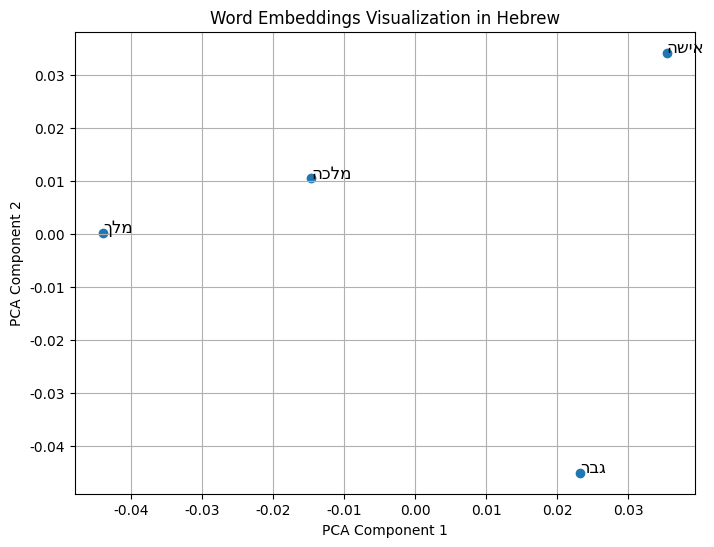

In [259]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

hebrew_sentences = [
    ['גבר', 'אישה', 'ילד', 'ילדה'],
    ['מלך', 'מלכה', 'נסיך', 'נסיכה'],
    ['גבר', 'חזק', 'אישה', 'חזקה'],
    ['מלך', 'שולט', 'במדינה'],
    ['מלכה', 'שולטת', 'במדינה'],
    ['גבר', 'אוכל', 'לחם'],
    ['אישה', 'אוכלת', 'לחם'],
]

# Train the Word2Vec model
model = Word2Vec(sentences=hebrew_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Words to visualize
words = ['מלך', 'מלכה', 'גבר', 'אישה']

# Get vectors for individual words
word_vectors = np.array([model.wv[word] for word in words])

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

# Annotate points with words (reversed for correct Hebrew display)
for i, word in enumerate(words):
    plt.annotate(word[::-1], (pca_result[i, 0], pca_result[i, 1]), fontsize=12)

plt.title("Word Embeddings Visualization in Hebrew")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

## Contextual embeddings (BERT, GPT)

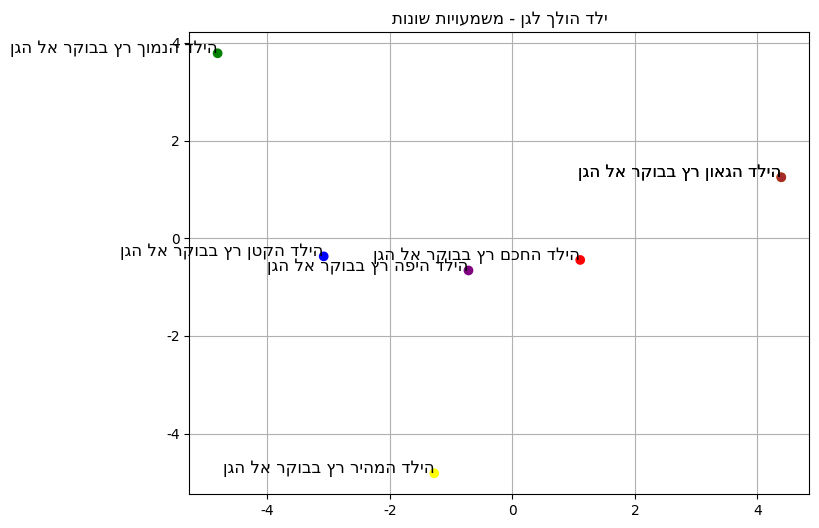

In [262]:
model_name = "intfloat/multilingual-e5-large"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Define the sentences
sentence1 = "הילד הקטן רץ בבוקר אל הגן"
sentence2 = "הילד הנמוך רץ בבוקר אל הגן"
sentence3 = "הילד החכם רץ בבוקר אל הגן"
sentence4 = "הילד היפה רץ בבוקר אל הגן"
sentence5 = "הילד המהיר רץ בבוקר אל הגן"
sentence6 = "הילד הגאון רץ בבוקר אל הגן"
sentence7 = "הילד הגאון רץ בבוקר אל הגן"

# Tokenize the sentences
inputs1 = tokenizer(sentence1, return_tensors="pt", padding=True, truncation=True)
inputs2 = tokenizer(sentence2, return_tensors="pt", padding=True, truncation=True)
inputs3 = tokenizer(sentence3, return_tensors="pt", padding=True, truncation=True)
inputs4 = tokenizer(sentence4, return_tensors="pt", padding=True, truncation=True)
inputs5 = tokenizer(sentence5, return_tensors="pt", padding=True, truncation=True)
inputs6 = tokenizer(sentence6, return_tensors="pt", padding=True, truncation=True)
inputs7 = tokenizer(sentence7, return_tensors="pt", padding=True, truncation=True)


# Get the embeddings using mean pooling instead of pooler_output
with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)
    outputs3 = model(**inputs3)
    outputs4 = model(**inputs4)
    outputs5 = model(**inputs5)
    outputs6 = model(**inputs6)
    outputs7 = model(**inputs7)

# Perform mean pooling (average over the token embeddings)
embedding1 = outputs1.last_hidden_state.mean(dim=1).numpy()
embedding2 = outputs2.last_hidden_state.mean(dim=1).numpy()
embedding3 = outputs3.last_hidden_state.mean(dim=1).numpy()
embedding4 = outputs4.last_hidden_state.mean(dim=1).numpy()
embedding5 = outputs5.last_hidden_state.mean(dim=1).numpy()
embedding6 = outputs6.last_hidden_state.mean(dim=1).numpy()
embedding7 = outputs7.last_hidden_state.mean(dim=1).numpy()

# Combine the embeddings into a single array
embeddings = np.vstack([embedding1, embedding2, embedding3, embedding4, embedding5, embedding6, embedding7])

# Perform PCA to reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(8, 6))

# Hebrew text does not need to be reversed for proper rendering in matplotlib
sentences = [sentence1, sentence2, sentence3, sentence4, sentence5, sentence6, sentence7]

# Plot the points with unique colors
colors = ['blue', 'green', 'red', 'purple', 'yellow', 'orange', 'brown']
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors)

# Annotate the points with the actual sentences in Hebrew
for i, sentence in enumerate(sentences):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], sentence[::-1], fontsize=12, ha='right')

# Set labels and title
plt.xlabel('')
plt.ylabel('')
plt.title('ילד הולך לגן - משמעויות שונות'[::-1])

# Show grid and plot
plt.grid(True)
plt.show()


![image.png](attachment:image.png)